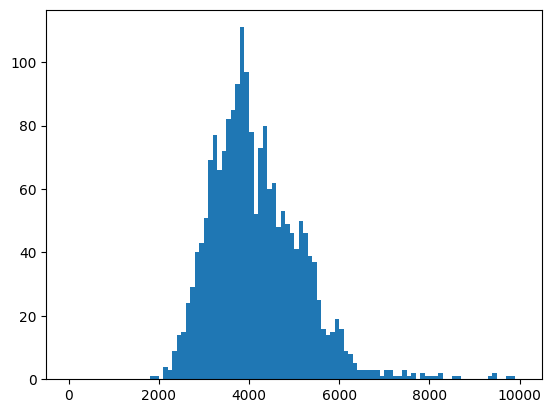

In [1]:
import pandas as pd

df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/reproduce-mgoksu-deotte/train_data_final/train_data_final.csv")
df = df.fillna('')

df = df[:2000]

df['context_len'] = df['context'].apply(lambda x: len(x))

import matplotlib.pyplot as plt

plt.hist(df['context_len'], bins=100, range=(0, 10000));

In [2]:

def preprocess_df(df):
    # Create a combined questions column
    df['questions'] = df[['A', 'B', 'C', 'D', 'E']].apply(
        lambda x: f'A) {x["A"]}\nB) {x["B"]} \nC) {x["C"]} \nD) {x["D"]} \nE) {x["E"]}', axis=1)

    def get_context_and_prompt_and_questions(row): 
        context = row['context']
        question = row['prompt'] 
        questions = row['questions']
        
        x = f"{context}. Given the context, try to answer this questions: \n\n{question}\nThese are the possible answers\n{questions}."
        return x

    df['context_and_prompt_and_questions'] = df.apply(lambda x: get_context_and_prompt_and_questions(x), axis=1)

    def get_proposed_answer_and_labels(x):
        options = "ABCDE"
        
        correct_answer_label = x['answer']
        
        # remove correct answer
        options = options.replace(correct_answer_label, "")
        
        wrong_answers = [x[option] for option in options]
        correct_answer = [x[correct_answer_label]]
        
        possible_answers = wrong_answers + correct_answer
        labels = [-1] * len(wrong_answers) + [1]
        return possible_answers, labels

    # Use separate column names for the expanded output
    df['proposed_answer'], df['is_answer_correct'] = zip(*df.apply(lambda x: get_proposed_answer_and_labels(x), axis=1))

    # explore by proposed_answer and is_answer_correct simulatenously
    df = df.explode(['proposed_answer', 'is_answer_correct'])

    return df


# train test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df = preprocess_df(train_df).reset_index(drop=True)
test_df = preprocess_df(test_df).reset_index(drop=True)


In [3]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses, LoggingHandler
from transformers import ProgressCallback
from torch.utils.data import DataLoader

# Create InputExamples
# Label examples with correct answer as 1
train_examples = [InputExample(texts=[row['context_and_prompt_and_questions'], row['proposed_answer']], label=float(row['is_answer_correct'])) for _, row in train_df.iterrows()]
test_examples = [InputExample(texts=[row['context_and_prompt_and_questions'], row['proposed_answer']], label=float(row['is_answer_correct'])) for _, row in test_df.iterrows()]

# DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)  # adjust batch_size as needed
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=32)  # adjust batch_size as needed


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/viktor/miniconda3/envs/torch-env did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


In [4]:
import torch
import numpy as np
import logging
from sentence_transformers.evaluation import SentenceEvaluator
from torch import nn
import torch.nn.functional as F



logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO, handlers=[LoggingHandler()])



# Initialize model and loss
# model = SentenceTransformer('distilbert-base-nli-mean-tokens')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model[1].pooling_mode_max_tokens = True

train_loss = losses.CosineSimilarityLoss(model=model)
# train_loss = CustomCosineSimilarityLoss()
# train_loss = losses.MSELoss(model=model)


# Training
num_epochs = 10  # Adjust as needed
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up




def check_max_similarity_correct(group):
    # 1) Find the index of the maximum cosine similarity
    max_cosine_idx = group['cosine_similarity'].idxmax()
    
    # Retrieve the row
    max_row = group.loc[[max_cosine_idx]]  # Using double brackets to ensure it remains as DataFrame
    
    # Check if the "is_answer_correct" value is 1 at that index
    max_row['is_max_similarity_correct'] = max_row['is_answer_correct'] == 1
    
    return max_row


def custom_evaluate(df):

    # 1. Compute embeddings
    context_embeddings = model.encode(df['context_and_prompt_and_questions'].tolist())
    proposed_answer_embeddings = model.encode(df['proposed_answer'].tolist())

    # 2. Calculate cosine similarity
    # This computes the cosine similarity for each pair (context, proposed_answer)
    cosine_similarities = np.sum(context_embeddings * proposed_answer_embeddings, axis=1) / (np.linalg.norm(context_embeddings, axis=1) * np.linalg.norm(proposed_answer_embeddings, axis=1))

    # Add cosine similarities to the dataframe
    df['cosine_similarity'] = cosine_similarities
    
    result_df = df.groupby('prompt').apply(check_max_similarity_correct).reset_index(drop=True)
    
    accuracy = result_df.is_max_similarity_correct.mean()
    
    return accuracy


class TrainEvalCallback(SentenceEvaluator):
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        train_acc = custom_evaluate(self.train_df)
        eval_acc = custom_evaluate(self.test_df)
        logging.info(f"Epoch {epoch}, Train Accuracy: {train_acc}, Eval Accuracy: {eval_acc}")
        # You can choose to return either the train_acc or eval_acc or an average of both.
        return eval_acc  # or train_acc or (train_acc + eval_acc) / 2, depending on your preference

train_eval_callback = TrainEvalCallback(train_df, test_df)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=train_eval_callback  # This should be evaluator, not callback
)


2023-09-16 20:01:20 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-09-16 20:01:20 - Use pytorch device: cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/250 [00:00<?, ?it/s]

/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:78                                                                                   │
│                                                                                                  │
│   75                                                                                             │
│   76 train_eval_callback = TrainEvalCallback(train_df, test_df)                                  │
│   77                                                                                             │
│ ❱ 78 model.fit(                                                                                  │
│   79 │   train_objectives=[(train_dataloader, train_loss)],                                      │
│   80 │   epochs=num_epochs,                                                                      │
│   81 │   warmup_steps=warmup_steps,                                                              │
│                                                                                                  │
│ /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/sentence_transformers/Sentenc │
│ eTransformer.py:721 in fit                                                                       │
│                                                                                                  │
│   718 │   │   │   │   │   │                                                                      │
│   719 │   │   │   │   │   │   skip_scheduler = scaler.get_scale() != scale_before_step           │
│   720 │   │   │   │   │   else:                                                                  │
│ ❱ 721 │   │   │   │   │   │   loss_value = loss_model(features, labels)                          │
│   722 │   │   │   │   │   │   loss_value.backward()                                              │
│   723 │   │   │   │   │   │   torch.nn.utils.clip_grad_norm_(loss_model.parameters(), max_grad   │
│   724 │   │   │   │   │   │   optimizer.step()                                                   │
│                                                                                                  │
│ /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/nn/modules/module.py:15 │
│ 01 in _call_impl                                                                                 │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/sentence_transformers/losses/ │
│ MSELoss.py:24 in forward                                                                         │
│                                                                                                  │
│   21 │                                                                                           │
│   22 │   def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):      │
│   23 │   │   rep = self.model(sentence_features[0])['sentence_embedding']                        │
│ ❱ 24 │   │   return self.loss_fct(rep, labels)             